**Download the aggregation network**.

In [1]:
import os
if not os.path.exists("weights"):
  os.makedirs("weights", exist_ok=True)
  !wget http://diffusion_hyperfeatures.berkeleyvision.org/weights/aggregation_network.pt -O weights/aggregation_network.pt

**Run the demo.** Run the following cells to compute semantic correspondences for real image pairs.

In [2]:
%load_ext autoreload
%autoreload 2
from archs.diffusion_extractor import DiffusionExtractor
from archs.aggregation_network import AggregationNetwork
from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  process_image,
  rescale_points,
  draw_correspondences,
  compute_pck,
  find_nn_source_correspondences,
  find_best_buddies_correspondences,
  find_cyclical_correspondences,
)
import os
import random
import torch

import einops
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import json
import torchvision

/home/g-luo/anaconda3/envs/dhf/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# Memory requirement is 13731MiB
device = "cuda:1"
config_path = "configs/real.yaml"
config = OmegaConf.load(config_path)
config = OmegaConf.to_container(config, resolve=True)

# dims is the channel dim for each layer (12 dims for Layers 1-12)
# idxs is the (block, sub-block) index for each layer (12 idxs for Layers 1-12)
diffusion_extractor = DiffusionExtractor(config, device)
dims = collect_dims(diffusion_extractor.unet, idxs=diffusion_extractor.idxs)

aggregation_network = AggregationNetwork(
    projection_dim=config["projection_dim"],
    feature_dims=dims,
    device=device,
    save_timestep=config["save_timestep"],
    num_timesteps=config["num_timesteps"]
)
aggregation_network.load_state_dict(torch.load(config["weights_path"], map_location="cpu")["aggregation_network"])

safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/g-luo/anaconda3/envs/dhf/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


<All keys matched successfully>

In [23]:
def load_image_pair(ann, load_size, device, image_path=""):
  img1_pil = Image.open(f"{image_path}/{ann['source_path']}").convert("RGB")
  img2_pil = Image.open(f"{image_path}/{ann['target_path']}").convert("RGB")
  source_size = img1_pil.size
  target_size = img2_pil.size

  # swap from (x, y) to (y, x)
  if "source_points" in ann:
    source_points, target_points = ann["source_points"], ann["target_points"]
    source_points = np.flip(source_points, 1)
    target_points = np.flip(target_points, 1)
    source_points = rescale_points(source_points, source_size, load_size)
    target_points = rescale_points(target_points, target_size, load_size)
  else:
    source_points, target_points = None, None

  img1, img1_pil = process_image(img1_pil, res=load_size)
  img2, img2_pil = process_image(img2_pil, res=load_size)
  img1, img2 = img1.to(device), img2.to(device)
  imgs = torch.cat([img1, img2])
  
  return source_points, target_points, img1_pil, img2_pil, imgs

def load_saliency_pair(ann, output_size, device, saliency_path=""):
  def _load_saliency(path):
    if os.path.exists(path):
      saliency_pil = Image.open(path).convert("L")
      saliency_map, _ = process_image(saliency_pil, res=output_size, range=(0, 1))
      saliency_map = einops.rearrange(saliency_map, 'b c h w -> (b c) (h w)')
    else:
      saliency_map = torch.ones((1, output_size[0] * output_size[1]))
    saliency_map = saliency_map.to(device)
    return saliency_map
  saliency_map1 = _load_saliency(f"{saliency_path}/{ann['source_path']}")
  saliency_map2 = _load_saliency(f"{saliency_path}/{ann['target_path']}")
  return saliency_map1, saliency_map2

def reshape_descriptors(img1_feats, img2_feats):
  b, d, w, h = img1_feats.shape
  descriptors1 = img1_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  descriptors2 = img2_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  return descriptors1, descriptors2

def postprocess_points(source_points, predicted_points, output_size, load_size):
  source_points = source_points.detach().cpu().numpy()
  predicted_points = predicted_points.detach().cpu().numpy()
  source_points = rescale_points(source_points, output_size, load_size)
  predicted_points = rescale_points(predicted_points, output_size, load_size)
  return source_points, predicted_points

**Compute semantic keypoint matches.** Use one of the correspondence functions:
- `nearest_neighbors`: For a set of annotated source_points, compute the nearest neighbor predicted_points.
- `best_buddies`: Compute the top-k pairs of source_points, predicted_points using the [best buddies algorithm](https://github.com/ShirAmir/dino-vit-features) (Amir et. al., ECCVW 2022).

In [25]:
image_path = "assets/spair/images"
saliency_path = "assets/spair/odise"
annotation_path = "annotations/spair_71k_test-6.json"
load_size = (224, 224)
output_size = (config["output_resolution"], config["output_resolution"])

# Select from [nearest_neighbors, best_buddies]
correspondence_function = "nearest_neighbors"
# Number of correspondences to display when using [best_buddies]
num_pairs = 10

/home/g-luo/remote_home/dhf/diffusion_hyperfeatures/archs/aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


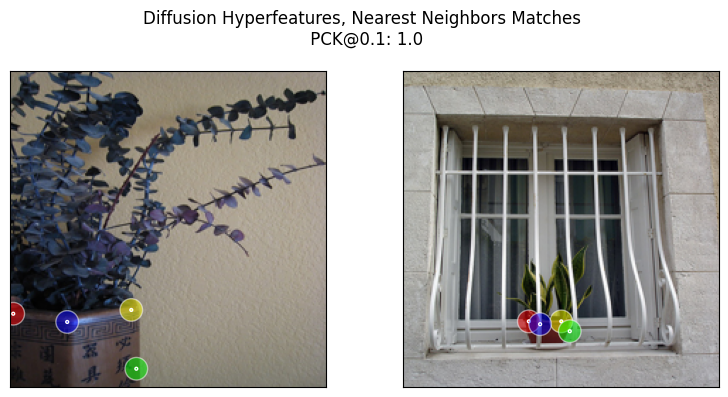

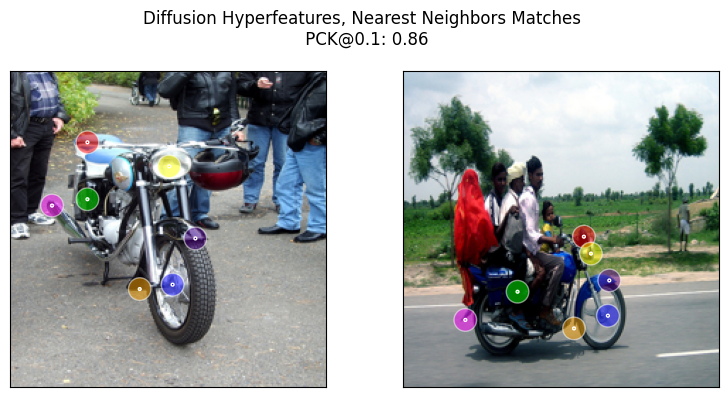

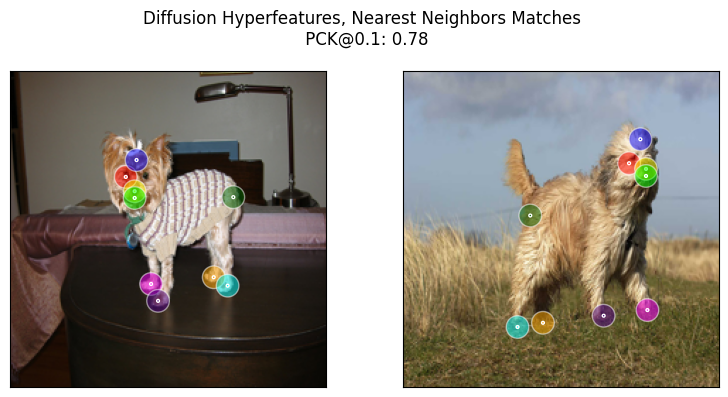

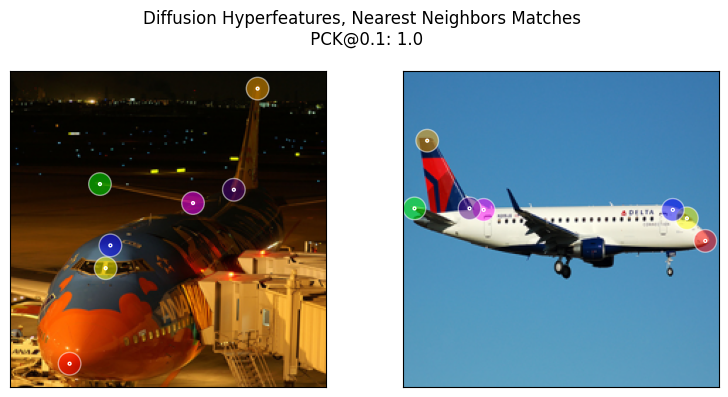

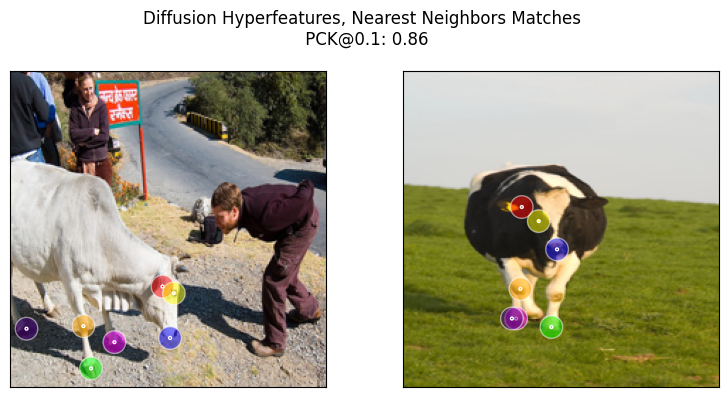

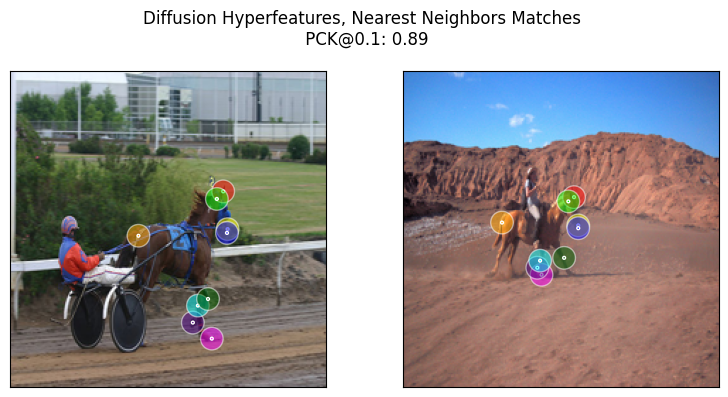

In [26]:
for ann in json.load(open(annotation_path)):
  source_points, target_points, img1_pil, img2_pil, imgs = load_image_pair(ann, load_size, device, image_path)
  
  with torch.inference_mode():
    with torch.autocast("cuda"):
      feats, _ = diffusion_extractor.forward(imgs)
      b, s, l, w, h = feats.shape
      diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
      img1_hyperfeats = diffusion_hyperfeats[0][None, ...]
      img2_hyperfeats = diffusion_hyperfeats[1][None, ...]

  if correspondence_function == "nearest_neighbors":
    _, predicted_points = find_nn_source_correspondences(img1_hyperfeats, img2_hyperfeats, source_points, output_size, load_size)
    predicted_points = predicted_points.detach().cpu().numpy()
    distances, pck_metric = compute_pck(predicted_points, target_points, load_size)
    title = f"Diffusion Hyperfeatures, Nearest Neighbors Matches \n PCK@0.1: {pck_metric.round(decimals=2)}"
  elif correspondence_function == "best_buddies":
    descriptors1, descriptors2 = reshape_descriptors(img1_hyperfeats, img2_hyperfeats)
    saliency_map1, saliency_map2 = load_saliency_pair(ann, output_size, img1_hyperfeats.device, saliency_path)
    source_points, predicted_points = find_best_buddies_correspondences(descriptors1, descriptors2, saliency_map1, saliency_map2, num_pairs=num_pairs)
    source_points, predicted_points = postprocess_points(source_points, predicted_points, output_size, load_size)
    title = "Diffusion Hyperfeatures, Best Buddies Matches"
  else:
    raise NotImplementedError
  
  draw_correspondences(source_points, predicted_points, img1_pil, img2_pil, title=title)
  plt.show()